## <span color = 'red'> Peaks and Holes Forming Analysis 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import linregress
import cv2
from preprocessing import preprocessing_v2 as pp
from pathlib import Path
from utils.file_util_exec import path_to_str
from utils import analysis_utils as au
plt.rcParams['font.size'] = 20

In [12]:
DATA_PATH = Path(r'D:\amityu\backoffice_data\\')
movie_list = ['130721_CCA60', 'cca120_am200', 'control_1_050721']
movie =Path(movie_list[0])
MOVIE_PATH = DATA_PATH /  movie 
GRAPH_PATH = Path('C:/Users/amityu/Gel_Sheet_Graph/')
ex_data = pp.get_ex_data(path_to_str(MOVIE_PATH) )
OUTPUT_PATH = GRAPH_PATH /Path('coarsening')


In [13]:
# Load the blob dataframe

if_surface = True
if_membrane= not if_surface
if if_surface:
    manifold_name = 'boundary'
    df = pd.read_csv(MOVIE_PATH / Path('np/surface_blobs.csv'))
    image_sequence = pp.get_merged_spike(path_to_str(MOVIE_PATH),ex_data)
if if_membrane:
    manifold_name = 'membrane'
    gel = np.load(MOVIE_PATH/ Path('np/gel_norm.npy'))
    df = pd.read_csv(MOVIE_PATH / Path('np/membrane_blobs.csv'))
    membrane = np.load(MOVIE_PATH/ Path('np/membrane.npy'))
    image_sequence = au.get_surface_intensity(gel, membrane)
# Display the first few rows
print(df.head())

# Example of the dataframe structure:
#    frame     y      x   sigma radius height intensity
# 0      1  100.5  150.3   5.2
# 1      1  200.7  250.8   4.8
# 2      2  105.2  155.1   5.5
# ...


   Unnamed: 0      y      x      sigma     radius     height  intensity  frame
0           0  350.0  227.0   7.444444  10.528034  34.669130   1.072511      0
1           1  483.0  138.0  10.666667  15.084945  35.755476   1.194596      0
2           2  393.0  252.0  10.666667  15.084945  36.365565   1.181254      0
3           3   80.0  511.0   7.444444  10.528034  35.944732   1.040190      0
4           4  180.0  104.0  13.888889  19.641855  35.807430   1.168114      0


Total number of frames: 62
Total number of blobs detected: 156338


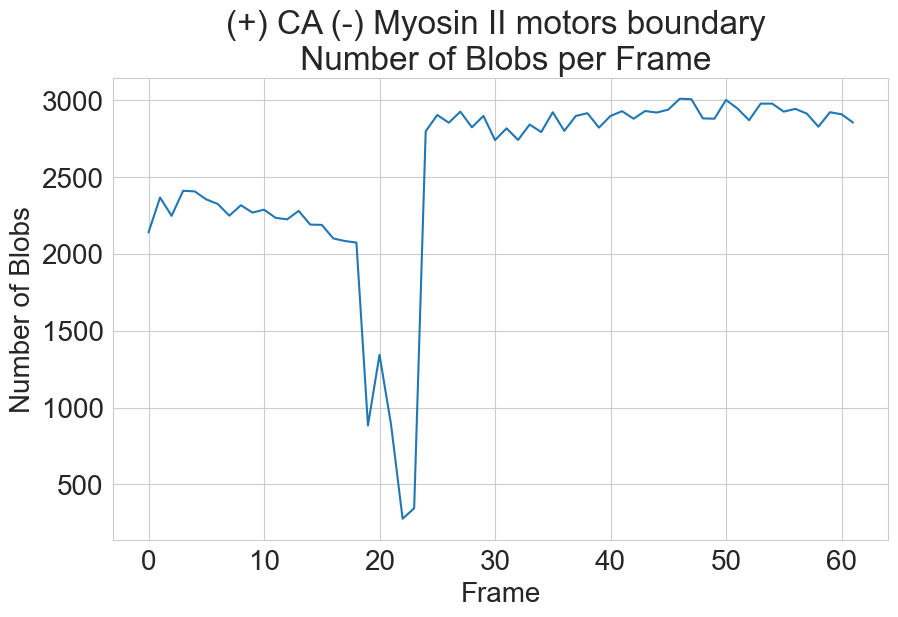

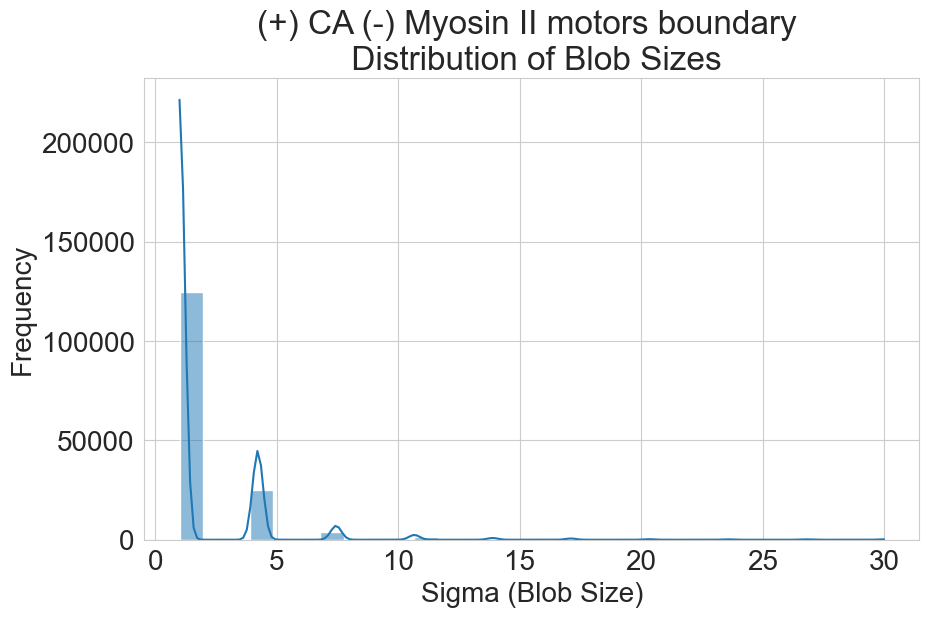

In [14]:
# Total number of frames
num_frames = df['frame'].nunique()
print(f"Total number of frames: {num_frames}")

# Total number of blobs
total_blobs = len(df)
print(f"Total number of blobs detected: {total_blobs}")

# Blobs per frame
blobs_per_frame = df['frame'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=blobs_per_frame.index, y=blobs_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Number of Blobs')
plt.title(f'{ex_data["name"]} {manifold_name} \n Number of Blobs per Frame')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_n_blob.png'))

plt.show()

# Distribution of blob sizes (sigma)
plt.figure(figsize=(10, 6))
sns.histplot(df['sigma'], bins=30, kde=True)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Frequency')
plt.title(f'{ex_data["name"]} {manifold_name} \n Distribution of Blob Sizes')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_blob_distribution.png'))

plt.show()


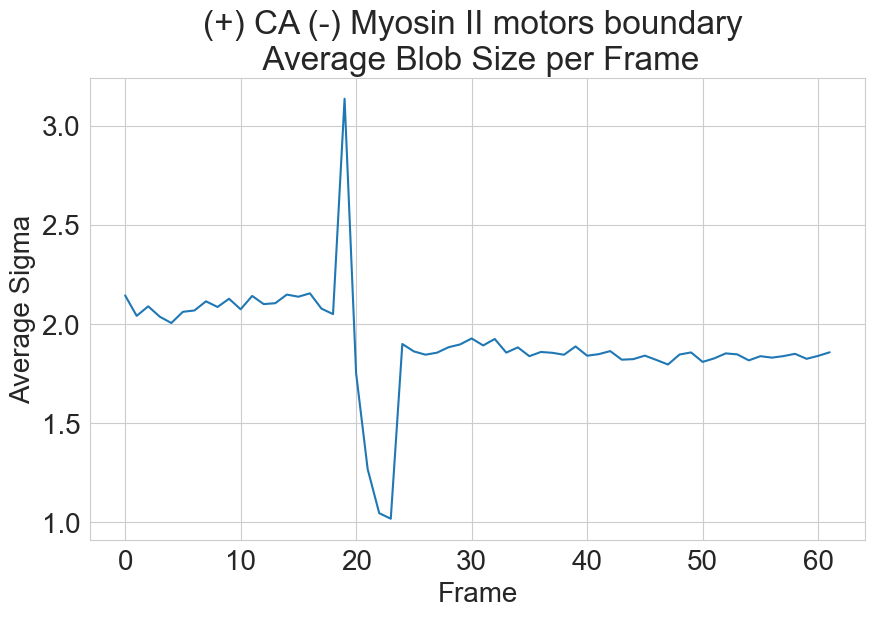

Coarsening exponent (slope): 0.024


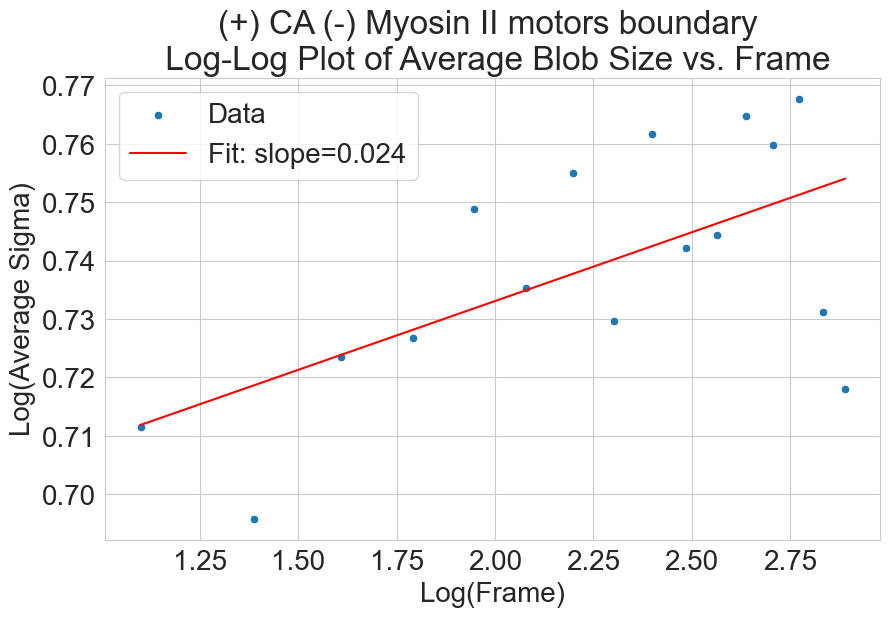

In [15]:
# Average blob size per frame
avg_sigma_per_frame = df.groupby('frame')['sigma'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sigma_per_frame.index, y=avg_sigma_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Sigma')
plt.title(f'{ex_data["name"]} {manifold_name} \n Average Blob Size per Frame')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_size_per_frame.png'))
plt.show()

# Fit a linear model to log-average sigma vs log-time to determine coarsening exponent
# Assuming frame number is proportional to time

log_time = np.log(avg_sigma_per_frame.index.values[3:19])
log_sigma = np.log(avg_sigma_per_frame.values[3:19])

slope, intercept, r_value, p_value, std_err = linregress(log_time, log_sigma)
print(f"Coarsening exponent (slope): {slope:.3f}")

# Plot with fitted line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log_time, y=log_sigma, label='Data')
plt.plot(log_time, intercept + slope * log_time, 'r', label=f'Fit: slope={slope:.3f}')
plt.xlabel('Log(Frame)')
plt.ylabel('Log(Average Sigma)')
plt.title(f'{ex_data["name"]} {manifold_name} \n Log-Log Plot of Average Blob Size vs. Frame')
plt.legend()
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_loglog.png'))
plt.show()


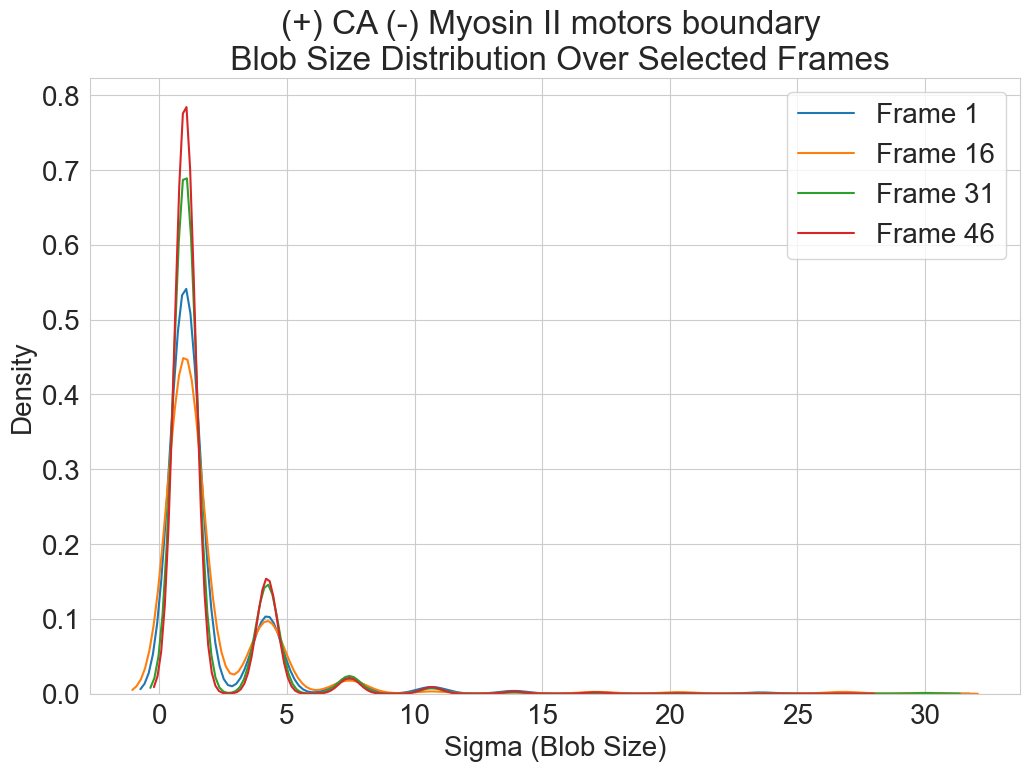

In [16]:
# Select frames to visualize distributions
selected_frames = np.linspace(1, num_frames, num=5, dtype=int)

plt.figure(figsize=(12, 8))
for frame in selected_frames:
    subset = df[df['frame'] == frame]
    sns.kdeplot(subset['sigma'], label=f'Frame {frame}')
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Density')
plt.title(f'{ex_data["name"]} {manifold_name} \n Blob Size Distribution Over Selected Frames')
plt.legend()
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_distribution.png'))
plt.show()


In [17]:
np.log(19)
np.exp(1.1)

3.0041660239464334

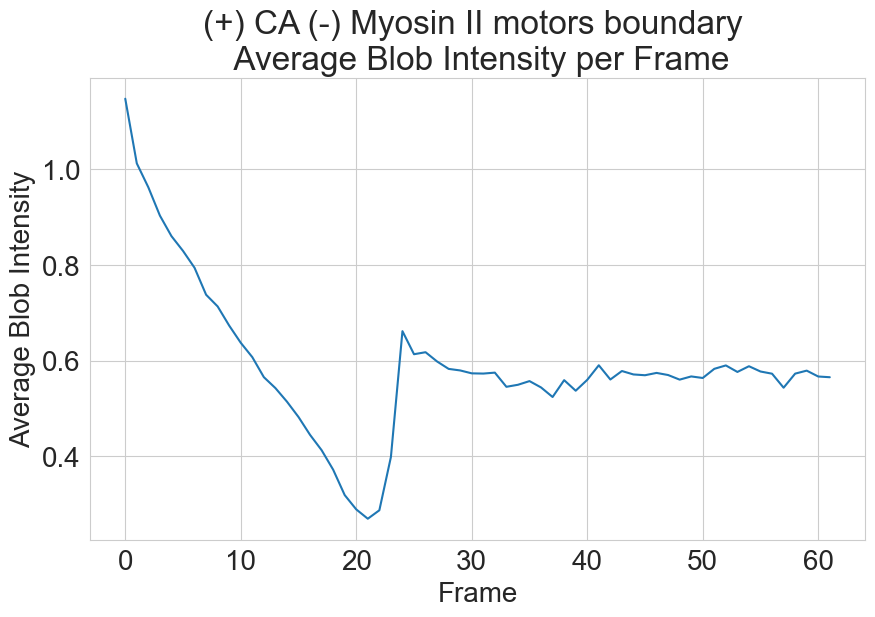

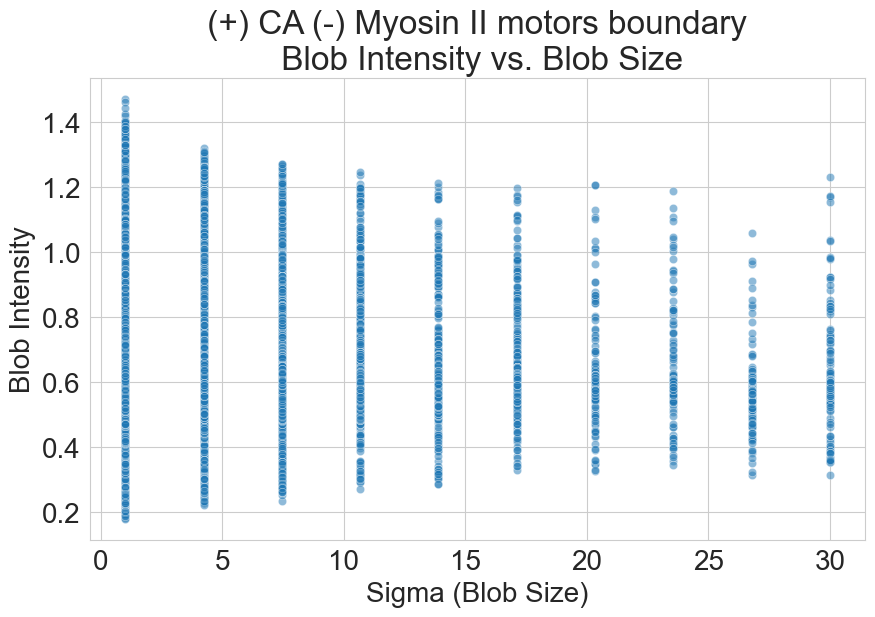

Correlation between blob size and intensity: 0.042


In [18]:
# Average intensity per frame
avg_intensity_per_frame = df.groupby('frame')['intensity'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_intensity_per_frame.index, y=avg_intensity_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Blob Intensity')
plt.title(f'{ex_data["name"]} {manifold_name} \n Average Blob Intensity per Frame')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_intensity_per_frame.png'))
plt.show()

# Correlation between blob size and intensity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sigma', y='intensity', data=df, alpha=0.5)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Blob Intensity')
plt.title(f' {ex_data["name"]} {manifold_name} \n Blob Intensity vs. Blob Size')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_intensity_vs_size.png'))
plt.show()

# Compute correlation coefficient
correlation = df['sigma'].corr(df['intensity'])
print(f"Correlation between blob size and intensity: {correlation:.3f}")


In [19]:
from scipy.spatial import cKDTree

# Initialize a dictionary to hold tracks
tracks = {}
current_track_id = 0

# Sort dataframe by frame
df_sorted = df.sort_values('frame')

# Parameters
max_distance = 20  # Maximum distance to consider the same blob across frames

# Iterate through frames
for frame in range(1, num_frames + 1):
    frame_blobs = df_sorted[df_sorted['frame'] == frame]
    if frame == 1:
        # Initialize tracks with first frame
        for idx, blob in frame_blobs.iterrows():
            tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
            df_sorted.at[idx, 'track_id'] = current_track_id
            current_track_id += 1
    else:
        # Get previous frame blobs with track IDs
        prev_frame = frame - 1
        prev_blobs = df_sorted[df_sorted['frame'] == prev_frame]
        prev_coords = prev_blobs[['y', 'x']].values
        prev_ids = prev_blobs['track_id'].values
        if len(prev_coords) == 0:
            # No previous blobs to track
            for idx, blob in frame_blobs.iterrows():
                tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
                df_sorted.at[idx, 'track_id'] = current_track_id
                current_track_id += 1
            continue
        # Build KD-tree for previous blobs
        tree = cKDTree(prev_coords)
        # Current frame blob coordinates
        current_coords = frame_blobs[['y', 'x']].values
        # Query nearest neighbors
        distances, indices = tree.query(current_coords, distance_upper_bound=max_distance)
        for i, (distance, index) in enumerate(zip(distances, indices)):
            if distance != np.inf:
                # Assign the track ID of the nearest previous blob
                track_id = prev_ids[index]
                tracks[track_id]['frames'].append(frame)
                tracks[track_id]['y'].append(current_coords[i][0])
                tracks[track_id]['x'].append(current_coords[i][1])
                tracks[track_id]['sigma'].append(frame_blobs.iloc[i]['sigma'])
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = track_id
            else:
                # Assign a new track ID
                tracks[current_track_id] = {'frames': [frame], 'y': [current_coords[i][0]], 'x': [current_coords[i][1]], 'sigma': [frame_blobs.iloc[i]['sigma']]}
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = current_track_id
                current_track_id += 1

# Display some tracks
for track_id, track in list(tracks.items())[:5]:
    print(f"Track {track_id}: Frames {track['frames']}, Positions {list(zip(track['y'], track['x']))}, Sigma {track['sigma']}")


Track 0: Frames [1, 2, 3], Positions [(199.0, 143.0), (198.0, 145.0), (244.0, 409.0)], Sigma [1.0, 1.0, 4.222222222222222]
Track 1: Frames [1, 2], Positions [(180.0, 238.0), (180.0, 238.0)], Sigma [1.0, 1.0]
Track 2: Frames [1], Positions [(232.0, 464.0)], Sigma [1.0]
Track 3: Frames [1, 2, 3], Positions [(265.0, 499.0), (261.0, 498.0), (385.0, 477.0)], Sigma [1.0, 1.0, 1.0]
Track 4: Frames [1, 2, 3, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9], Positions [(53.0, 505.0), (50.0, 506.0), (128.0, 99.0), (360.0, 499.0), (357.0, 493.0), (318.0, 13.0), (180.0, 386.0), (449.0, 133.0), (74.0, 359.0), (65.0, 355.0), (129.0, 109.0), (216.0, 38.0), (256.0, 335.0)], Sigma [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.222222222222222, 1.0, 1.0, 1.0, 4.222222222222222]


In [20]:
import matplotlib.patches as patches
'''from matplotlib import animation

# Load all images
images = image_sequence

# Normalize images
images = [img / img.max() for img in images]

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

def init():
    ax.imshow(images[0], cmap='gray')
    return []

def animate(frame_num):
    ax.clear()
    ax.imshow(images[frame_num], cmap='gray')
    # Plot blobs
    frame = frame_num + 1  # Assuming frame numbering starts at 1
    blobs = df[df['frame'] == frame]
    for _, blob in blobs.iterrows():
        circ = patches.Circle((blob['x'], blob['y']), radius=blob['sigma']*3, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(circ)
    ax.set_title(f'{ex_data["name"]} {manifold_name} \n Frame {frame}')
    return []

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_frames, interval=200, blit=False)

# To display the animation in a Jupyter notebook
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# To save the animation as a GIF
anim.save('coarsening_animation.gif', writer='imagemagick')
'''

'from matplotlib import animation\n\n# Load all images\nimages = image_sequence\n\n# Normalize images\nimages = [img / img.max() for img in images]\n\n# Create a figure\nfig, ax = plt.subplots(figsize=(8, 8))\n\ndef init():\n    ax.imshow(images[0], cmap=\'gray\')\n    return []\n\ndef animate(frame_num):\n    ax.clear()\n    ax.imshow(images[frame_num], cmap=\'gray\')\n    # Plot blobs\n    frame = frame_num + 1  # Assuming frame numbering starts at 1\n    blobs = df[df[\'frame\'] == frame]\n    for _, blob in blobs.iterrows():\n        circ = patches.Circle((blob[\'x\'], blob[\'y\']), radius=blob[\'sigma\']*3, edgecolor=\'red\', facecolor=\'none\', linewidth=1)\n        ax.add_patch(circ)\n    ax.set_title(f\'{ex_data["name"]} {manifold_name} \n Frame {frame}\')\n    return []\n\nanim = animation.FuncAnimation(fig, animate, init_func=init,\n                               frames=num_frames, interval=200, blit=False)\n\n# To display the animation in a Jupyter notebook\n# from IPython.d

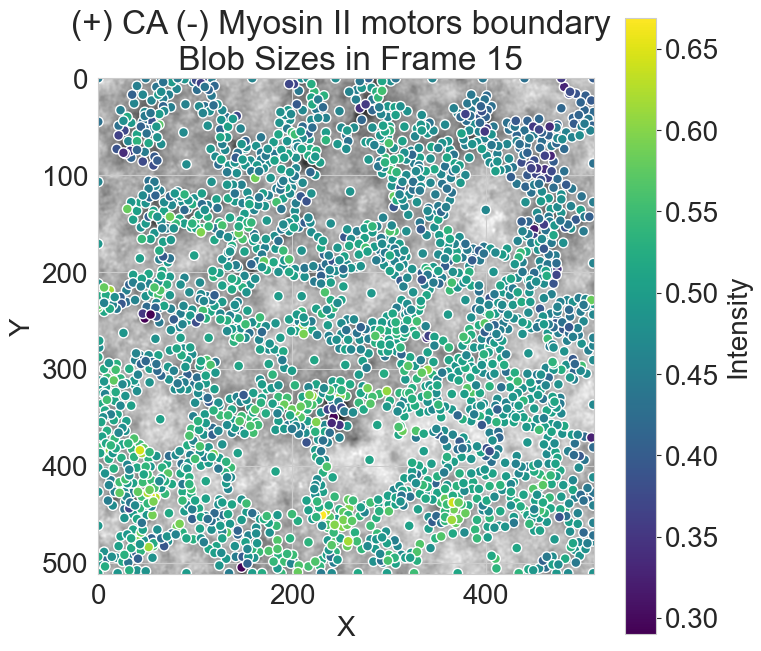

In [21]:
import matplotlib.colors as colors

# Select a frame to visualize
selected_frame = 15  # For example, the last frame

# Load the selected image
image = image_sequence[selected_frame]
if image.ndim == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = image / image.max()

# Get blobs for the selected frame
blobs = df[df['frame'] == selected_frame]

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
scatter = plt.scatter(blobs['x'], blobs['y'], c=blobs['intensity'], cmap='viridis', s=50, edgecolor='white')
plt.colorbar(scatter, label='Intensity')
plt.title(f'{ex_data["name"]} {manifold_name} \n Blob Sizes in Frame {selected_frame}')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_blob_frame{selected_frame}.png'))
plt.show()


Total number of frames loaded: 62


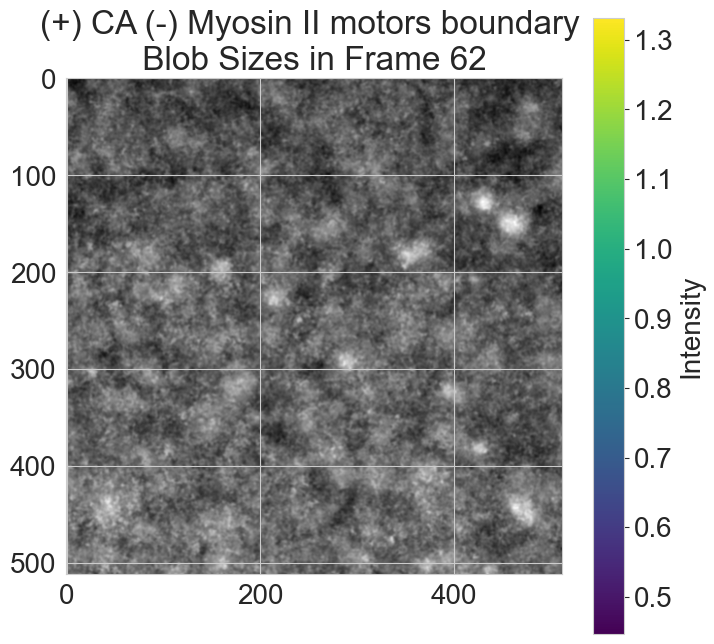

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import animation
import pandas as pd
import numpy as np
import cv2
import os

# Total number of frames
num_frames = len(image_sequence)
print(f"Total number of frames loaded: {num_frames}")

# ----------------------------
# Step 2: Prepare the Plot
# ----------------------------

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize the plot elements we want to animate
# Display the first image
initial_image = image_sequence[0]
img_display = ax.imshow(initial_image, cmap='gray', animated=True)

# Extract blobs for the first frame
selected_frame = 1  # Assuming frame indexing starts at 1
blobs = df[df['frame'] == selected_frame]

# Create the scatter plot for blobs
scatter = ax.scatter(blobs['x'], blobs['y'], c=blobs['intensity'], cmap='viridis', s=50, edgecolor='white', animated=True)

# Add a colorbar for sigma
cbar = plt.colorbar(scatter, ax=ax, label='Intensity')

# Set plot titles and labels
title = ax.set_title(f'{ex_data["name"]} {manifold_name} \n Blob Sizes and Intensity in Frame {selected_frame}')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# ----------------------------
# Step 3: Define the Animation Function
# ----------------------------

def animate(frame_num):
    """
    Update the image and scatter plot for the given frame number.
    """
    # Update the image
    ax.clear()

    img = image_sequence[frame_num]
    ax.imshow(img, cmap='gray')
    # Clear previous scatter

    # Get blobs for the current frame (assuming frame indexing starts at 1)
    current_frame = frame_num + 1
    blobs = df[df['frame'] == current_frame]

    # Update scatter plot with new blobs
    scatter = ax.scatter(blobs['x'], blobs['y'], c=blobs['sigma'], cmap='viridis', s=50, edgecolor='white')

    # Update title
    ax.set_title(f'{ex_data["name"]} {manifold_name} \n Blob Sizes in Frame {current_frame} ')

    return img_display, scatter, title

# ----------------------------
# Step 4: Create the Animation
# ----------------------------

# Define the number of frames and interval
anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200, blit=False)

# ----------------------------
# Step 5: Display or Save the Animation
# ----------------------------

# Option 1: Display the animation inline (useful for Jupyter Notebooks)
# Uncomment the following lines if you're using a Jupyter Notebook

# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option 2: Save the animation as a GIF
# Ensure you have ImageMagick installed: https://imagemagick.org/script/download.php

# Replace 'coarsening_animation.gif' with your desired output path
anim.save(OUTPUT_PATH /  Path(f'{ex_data["name"]}_{manifold_name}_animation.mp4'),  fps=5)

# Option 3: Save the animation as an MP4 video
# Ensure you have ffmpeg installed: https://ffmpeg.org/download.html

# anim.save('coarsening_animation.mp4', writer='ffmpeg', fps=5)

# ----------------------------
# Step 6: Show the Plot (Optional)
# ----------------------------

plt.show()


In [65]:
import numpy as np
def get_line_scan(alpha, y0, x0):
    
    # calculate the slope
    m = np.tan(alpha)
    
    x = np.arange(512)
    # y = mx + c => c = y - mx
    c = y0 - m * x0
    y = (m * x + c).astype(int)
    y[y>511] = 511
    y[y<0] = 0
    return y

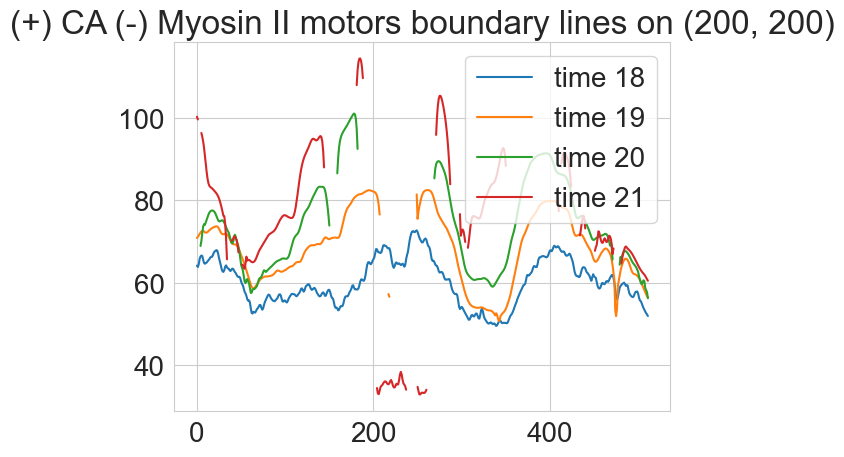

In [89]:
t, y0, x0 = 20, 200,200
for t  in range(18,22):
    for alpha in np.arange(0, np.pi, np.pi/4)[[0]]:
        plt.plot(image_sequence[t][get_line_scan(alpha,y0,x0)][x0], label = f'time {t}')
plt.legend(loc='upper right')
plt.title(f'{ex_data["name"]} {manifold_name} lines on {y0,x0}')
plt.savefig(OUTPUT_PATH / Path(f'{movie}_{manifold_name}_line_scan.png'))
plt.show()
    

In [77]:
np.arange(0, np.pi, np.pi/6)

array([0.        , 0.52359878, 1.04719755, 1.57079633, 2.0943951 ,
       2.61799388])

In [23]:
# Using the previously computed log-log slope
print(f"Coarsening exponent: {slope:.3f}")

# The coarsening rate can be inferred from the slope
# For example, if sigma ~ t^n, then slope ≈ n


Coarsening exponent: 0.024


In [24]:
''' 
#Compute the characteristic size (e.g., average sigma)
char_size = avg_sigma_per_frame.values

# Normalize blob sizes
df['sigma_normalized'] = df.apply(lambda row: row['sigma'] / char_size[int(row['frame']) - 1], axis=1)

# Plot normalized size distributions
plt.figure(figsize=(10, 6))      
for frame in selected_frames:
    subset = df[df['frame'] == frame]
    sns.kdeplot(subset['sigma_normalized'], label=f'Frame {frame}')
plt.xlabel('Normalized Sigma')
plt.ylabel('Density')
plt.title('Scaling Collapse of Blob Size Distributions')
plt.legend()
plt.show()
'''

" \n#Compute the characteristic size (e.g., average sigma)\nchar_size = avg_sigma_per_frame.values\n\n# Normalize blob sizes\ndf['sigma_normalized'] = df.apply(lambda row: row['sigma'] / char_size[int(row['frame']) - 1], axis=1)\n\n# Plot normalized size distributions\nplt.figure(figsize=(10, 6))      \nfor frame in selected_frames:\n    subset = df[df['frame'] == frame]\n    sns.kdeplot(subset['sigma_normalized'], label=f'Frame {frame}')\nplt.xlabel('Normalized Sigma')\nplt.ylabel('Density')\nplt.title('Scaling Collapse of Blob Size Distributions')\nplt.legend()\nplt.show()\n"